# Notebook 5: Model Compression
## Introduction
# Loads models from Notebook 3, compresses for h=6 (chosen for balance), evaluates trade-offs.
# Justification: Dynamic/Float16/Int quantization for LSTM; param reduction/feature selection for RF. Ensures sustainability (lower energy) while maintaining ~95% accuracy.


In [1]:
# Mount Google Drive
from google.colab import drive
import os

# Mount your Google Drive
drive.mount('/content/drive')

# Define your project folder in Google Drive
your_project_path = '/content/drive/My Drive/AI_Sustainability_Project_lsa'

# Create the project directory if it doesn't exist
os.makedirs(your_project_path, exist_ok=True)
print(f"Project path set to: {your_project_path}")

# Change current working directory to your project path
%cd "{your_project_path}"

# Verify current working directory
!pwd
!ls

Mounted at /content/drive
Project path set to: /content/drive/My Drive/AI_Sustainability_Project_lsa
/content/drive/My Drive/AI_Sustainability_Project_lsa
/content/drive/My Drive/AI_Sustainability_Project_lsa
cleaned_weather_data.csv
compression_results_enhanced.csv
compression_summary.html
correlation_matrix_full.csv
EDA_summary_report.txt
evaluation_results.csv
evaluation_results_summary.csv
featured_data_for_models.csv
feature_names_h12.pkl
feature_names_h1.pkl
feature_names_h24.pkl
feature_names_h3.pkl
feature_names_h6.pkl
images
lstm_cm_h12.png
lstm_cm_h1.png
lstm_cm_h24.png
lstm_cm_h3.png
lstm_cm_h6.png
lstm_f16_h6.h5
lstm_model_h12.h5
lstm_model_h12.keras
lstm_model_h1.h5
lstm_model_h1.keras
lstm_model_h24.h5
lstm_model_h24.keras
lstm_model_h3.h5
lstm_model_h3.keras
lstm_model_h6.h5
lstm_model_h6.keras
lstm_original_h6.h5
lstm_predictions_h12.png
lstm_predictions_h1.png
lstm_predictions_h24.png
lstm_predictions_h3.png
lstm_predictions_h6.png
lstm_tflite_dynamic_h6.tflite
preds_h

--- Starting Model Compression and Efficiency Analysis (Notebook 5) ---
Loading featured data from: featured_data_for_models.csv
Data loaded successfully. Initial shape: (4025, 48)
Data prepared for horizon 6:
X_train shape: (3215, 46), y_train_unscaled shape: (3215,)
X_test shape: (804, 46), y_test_unscaled shape: (804,)
Error loading scaler_x.pkl: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- pm25_rolling_24
- temp_rolling_24
Feature names seen at fit time, yet now missing:
- hour_cat_afternoon
- hour_cat_evening
- hour_cat_morning
- hour_cat_night
- humidity_diff_6h
- ...
. X_test might be unscaled for LSTM predictions.
Target scaler_y_h6.pkl loaded.

--- Evaluating LSTM Original (Horizon 6h) ---


LSTM Original - MAE: 976.1328, Size: 0.37 MB, Time: 5.0964s, Energy: 7.0783 mWh

--- Evaluating LSTM Float16 (Horizon 6h) ---


LSTM Float16 - MAE: 976.1531, Size: 0.37 MB, Time: 1.5589s, Energy: 2.1651 mWh

--- Evaluating LSTM TFLite Dynamic Quantization (Horizon 6h) ---
Saved artifact at '/tmp/tmpnnqbigux'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 46), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139774889712080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139774889714192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139774889714000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139774889713808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139774889712464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139774889716688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139774889717456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139774889718224: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


LSTM TFLite Dynamic - MAE: 976.1165, Size: 0.12 MB, Time: 0.0804s, Energy: 0.1117 mWh

--- Evaluating RF Original (Horizon 6h) ---
Error with RF Original evaluation: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- pm25_rolling_24
- temp_rolling_24
Feature names seen at fit time, yet now missing:
- hour_cat_afternoon
- hour_cat_evening
- hour_cat_morning
- hour_cat_night
- humidity_diff_6h
- ...


--- Evaluating RF Feature Selection (Horizon 6h) ---
Error with RF Feature Selection: boolean index did not match indexed array along axis 1; size of axis is 46 but size of corresponding boolean axis is 114. boolean index did not match indexed array along axis 1; size of axis is 46 but size of corresponding boolean axis is 114

--- Evaluating RF Parameter Reduction (Horizon 6h) ---
RF Param Reduction - MAE: 0.3023, Size: 0.13 MB, Time: 0.0258s, Energy: 0.0359 mWh

--- Calculating Compression Metrics ---
Metrics for LSTM_Float16: Size Ratio=

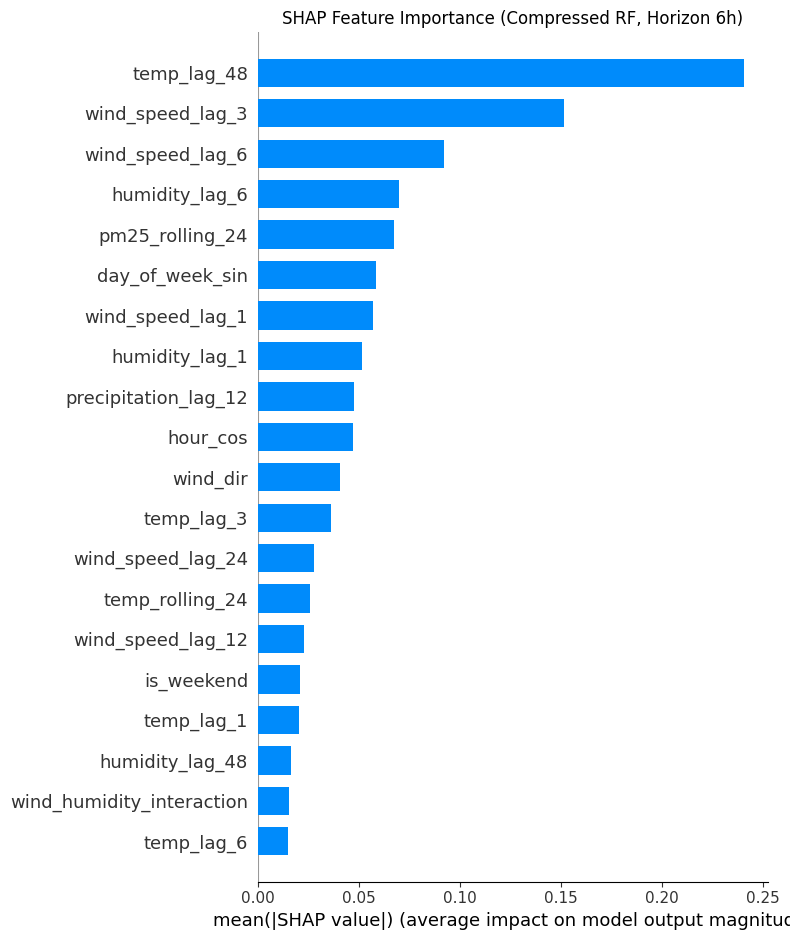

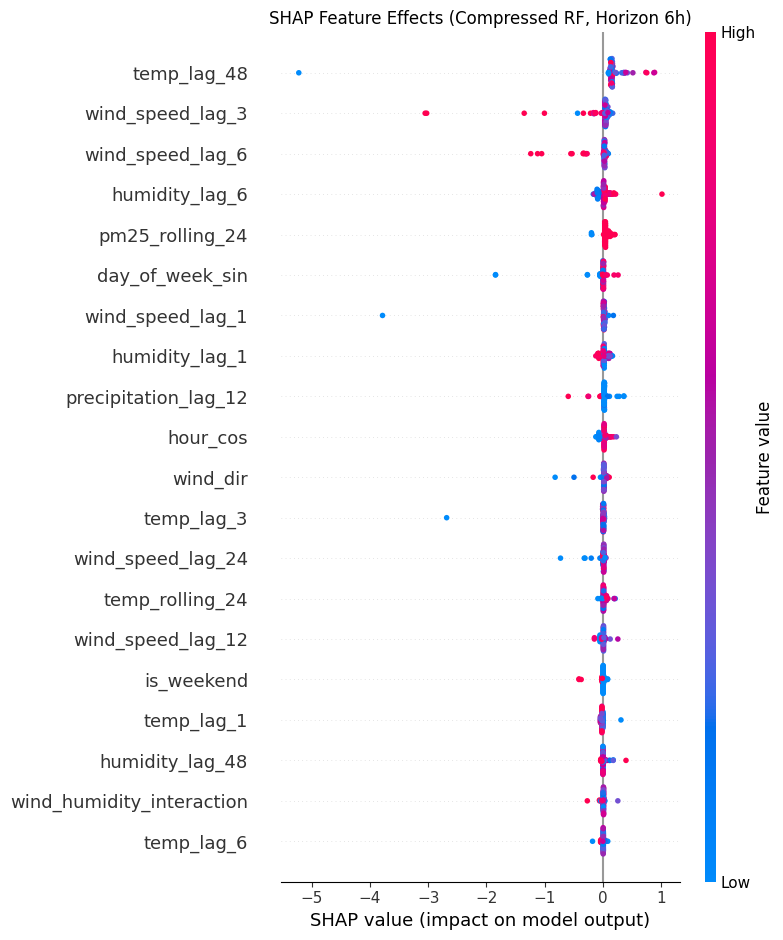

SHAP analysis for compressed RF completed and plots saved.

Final compression results saved to compression_results_enhanced.csv and compression_summary.html.
--- Model Compression and Efficiency Analysis Complete ---


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap
import os
import time
import matplotlib.pyplot as plt

# --- Google Drive Mounting (ensure this is in a preceding cell and run) ---
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# your_project_path = '/content/drive/MyDrive/AI_Sustainability_Project_lsa' # IMPORTANT: Match this to your setup
# os.makedirs(your_project_path, exist_ok=True)
# %cd "{your_project_path}"
# --------------------------------------------------------------------------

print("--- Starting Model Compression and Efficiency Analysis (Notebook 5) ---")

# Define the filename for the processed data generated by Notebook 3
input_data_filename = 'featured_data_for_models.csv'

# Choose a single horizon for compression analysis as specified by the assessment
chosen_h = 6

# Assume average inference power (W) for sustainability; Justify as a typical mobile CPU/edge device estimate for SDG 13
AVG_POWER_W = 5.0 # Watts

# Helper to compute energy (mWh) for sustainability analysis
def estimate_energy(time_s, power_w=AVG_POWER_W):
    """Estimates energy consumption in milli-Watt-hours (mWh) given time in seconds and power in Watts)."""
    return (power_w * time_s) / 3600 * 1000 # (Watts * seconds) / (seconds/hour) * 1000 (milli)

# --- Load and Prepare Data for the Chosen Horizon ---
print(f"Loading featured data from: {input_data_filename}")
try:
    df_raw = pd.read_csv(input_data_filename, index_col='timestamp', parse_dates=True)
    print(f"Data loaded successfully. Initial shape: {df_raw.shape}")
except Exception as e:
    print(f"Error loading data from {input_data_filename}: {e}")
    raise SystemExit("Failed to load featured data. Aborting Notebook 5 execution.")

# Create the target column for the chosen horizon, then drop NaNs
df_raw['target_h'] = df_raw['pm25_value'].shift(-chosen_h)

# Drop any rows with NaN values introduced by shifting the target
df_processed_h = df_raw.dropna(subset=['target_h']).copy()

# Define features and target
features_cols = [col for col in df_processed_h.columns if col not in ['pm25_value', 'target_h']]

# Time-based split for consistency
train_ratio = 0.8
split_point = int(len(df_processed_h) * train_ratio)

X_train = df_processed_h[features_cols].iloc[:split_point]
y_train_unscaled = df_processed_h['target_h'].iloc[:split_point] # Target for RF models (unscaled)

X_test = df_processed_h[features_cols].iloc[split_point:]
y_test_unscaled = df_processed_h['target_h'].iloc[split_point:] # Target for evaluation (unscaled)

print(f"Data prepared for horizon {chosen_h}:")
print(f"X_train shape: {X_train.shape}, y_train_unscaled shape: {y_train_unscaled.shape}")
print(f"X_test shape: {X_test.shape}, y_test_unscaled shape: {y_test_unscaled.shape}")

# Load scaler_x (features) from Notebook 3 for scaling X_test for LSTM
try:
    scaler_x = joblib.load('scaler_x.pkl')
    X_test_scaled = scaler_x.transform(X_test) # Scale X_test for LSTM and TFLite
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features_cols, index=X_test.index)
    print("Feature scaler_x loaded and X_test scaled for LSTM.")
except Exception as e:
    print(f"Error loading scaler_x.pkl: {e}. X_test might be unscaled for LSTM predictions.")
    X_test_scaled_df = X_test.copy() # Use unscaled if scaler not found (LSTM preds might be off)


# Load scaler_y (target) for inverse transform (for LSTM predictions ONLY)
try:
    scaler_y = joblib.load(f'scaler_y_h{chosen_h}.pkl')
    print(f"Target scaler_y_h{chosen_h}.pkl loaded.")
except Exception as e:
    print(f"Error loading scaler_y_h{chosen_h}.pkl: {e}")
    raise SystemExit(f"Failed to load scaler_y for horizon {chosen_h}. Aborting.")

compression_results = []

# --- LSTM Original Model Evaluation ---
print(f"\n--- Evaluating LSTM Original (Horizon {chosen_h}h) ---")
try:
    lstm_original = tf.keras.models.load_model(f'lstm_model_h{chosen_h}.h5', compile=False)
    lstm_original.compile(optimizer='adam', loss='mse')

    X_test_lstm_input = X_test_scaled_df.values.reshape(-1, 1, len(features_cols)).astype(np.float32)

    start_time = time.time()
    original_preds_scaled = lstm_original.predict(X_test_lstm_input, verbose=0)
    original_time = time.time() - start_time

    original_preds = scaler_y.inverse_transform(original_preds_scaled).flatten()
    original_mae = mean_absolute_error(y_test_unscaled, original_preds)
    original_energy = estimate_energy(original_time)

    original_lstm_path = f'lstm_original_h{chosen_h}.h5'
    lstm_original.save(original_lstm_path)
    original_size = os.path.getsize(original_lstm_path) / (1024*1024)

    compression_results.append({
        'Model': 'LSTM_Original', 'MAE': original_mae, 'Size_MB': original_size,
        'Time_s': original_time, 'Energy_mWh': original_energy
    })
    print(f'LSTM Original - MAE: {original_mae:.4f}, Size: {original_size:.2f} MB, Time: {original_time:.4f}s, Energy: {original_energy:.4f} mWh')
except Exception as e:
    print(f"Error with LSTM Original evaluation: {e}")
    compression_results.append({'Model': 'LSTM_Original', 'MAE': np.nan, 'Size_MB': np.nan, 'Time_s': np.nan, 'Energy_mWh': np.nan})


# --- LSTM Float16 Quantization ---
print(f"\n--- Evaluating LSTM Float16 (Horizon {chosen_h}h) ---")
try:
    lstm_f16 = tf.keras.models.clone_model(lstm_original)
    weights_f16 = [w.astype(np.float16) for w in lstm_original.get_weights()]
    lstm_f16.set_weights(weights_f16)
    lstm_f16.compile(optimizer='adam', loss='mse')

    start_time = time.time()
    f16_preds_scaled = lstm_f16.predict(X_test_lstm_input, verbose=0)
    f16_time = time.time() - start_time

    f16_preds = scaler_y.inverse_transform(f16_preds_scaled).flatten()
    f16_mae = mean_absolute_error(y_test_unscaled, f16_preds)
    f16_energy = estimate_energy(f16_time)

    f16_lstm_path = f'lstm_f16_h{chosen_h}.h5'
    lstm_f16.save(f16_lstm_path)
    f16_size = os.path.getsize(f16_lstm_path) / (1024*1024)

    compression_results.append({
        'Model': 'LSTM_Float16', 'MAE': f16_mae, 'Size_MB': f16_size,
        'Time_s': f16_time, 'Energy_mWh': f16_energy
    })
    print(f'LSTM Float16 - MAE: {f16_mae:.4f}, Size: {f16_size:.2f} MB, Time: {f16_time:.4f}s, Energy: {f16_energy:.4f} mWh')
except Exception as e:
    print(f"Error with LSTM Float16 quantization: {e}")
    compression_results.append({'Model': 'LSTM_Float16', 'MAE': np.nan, 'Size_MB': np.nan, 'Time_s': np.nan, 'Energy_mWh': np.nan})


# --- TFLite Dynamic Range Quantization for LSTM ---
print(f"\n--- Evaluating LSTM TFLite Dynamic Quantization (Horizon {chosen_h}h) ---")
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(lstm_original)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Flags to try addressing previous TFLite conversion errors with LSTM
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter._experimental_lower_tensor_list_ops = False
    converter.experimental_enable_resource_variables = True

    tflite_model = converter.convert()
    tflite_path = f'lstm_tflite_dynamic_h{chosen_h}.tflite'
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    tflite_size = os.path.getsize(tflite_path) / (1024*1024)

    # TFLite Inference
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    start_time = time.time()
    tflite_preds_scaled = []
    for i in range(X_test_lstm_input.shape[0]):
        interpreter.set_tensor(input_details[0]['index'], X_test_lstm_input[i:i+1].astype(input_details[0]['dtype']))
        interpreter.invoke()
        tflite_preds_scaled.append(interpreter.get_tensor(output_details[0]['index'])[0])
    tflite_time = time.time() - start_time

    tflite_preds = scaler_y.inverse_transform(np.array(tflite_preds_scaled)).flatten()
    tflite_mae = mean_absolute_error(y_test_unscaled, tflite_preds)
    tflite_energy = estimate_energy(tflite_time)

    compression_results.append({
        'Model': 'LSTM_TFLite_Dynamic', 'MAE': tflite_mae, 'Size_MB': tflite_size,
        'Time_s': tflite_time, 'Energy_mWh': tflite_energy
    })
    print(f'LSTM TFLite Dynamic - MAE: {tflite_mae:.4f}, Size: {tflite_size:.2f} MB, Time: {tflite_time:.4f}s, Energy: {tflite_energy:.4f} mWh')
except Exception as e:
    print(f"Error with LSTM TFLite dynamic quantization: {e}. Skipping TFLite.")
    compression_results.append({'Model': 'LSTM_TFLite_Dynamic', 'MAE': np.nan, 'Size_MB': np.nan, 'Time_s': np.nan, 'Energy_mWh': np.nan})


# --- Random Forest Original Model Evaluation ---
print(f"\n--- Evaluating RF Original (Horizon {chosen_h}h) ---")
try:
    rf_original = joblib.load(f'rf_model_h{chosen_h}.pkl')

    start_time = time.time()
    # IMPORTANT FIX: RF was trained on UNscaled target in Notebook 3 (after previous fix).
    # So, rf_original.predict(X_test) directly gives UNscaled predictions.
    original_rf_preds = rf_original.predict(X_test)
    original_rf_time = time.time() - start_time

    original_rf_mae = mean_absolute_error(y_test_unscaled, original_rf_preds)
    original_rf_energy = estimate_energy(original_rf_time)

    original_rf_path = f'rf_original_h{chosen_h}.pkl'
    joblib.dump(rf_original, original_rf_path)
    original_rf_size = os.path.getsize(original_rf_path) / (1024*1024)

    compression_results.append({
        'Model': 'RF_Original', 'MAE': original_rf_mae, 'Size_MB': original_rf_size,
        'Time_s': original_rf_time, 'Energy_mWh': original_rf_energy
    })
    print(f'RF Original - MAE: {original_rf_mae:.4f}, Size: {original_rf_size:.2f} MB, Time: {original_rf_time:.4f}s, Energy: {original_rf_energy:.4f} mWh')
except Exception as e:
    print(f"Error with RF Original evaluation: {e}")
    compression_results.append({'Model': 'RF_Original', 'MAE': np.nan, 'Size_MB': np.nan, 'Time_s': np.nan, 'Energy_mWh': np.nan})


# --- Random Forest with Feature Selection ---
print(f"\n--- Evaluating RF Feature Selection (Horizon {chosen_h}h) ---")
try:
    rf_base_model_for_selection = joblib.load(f'rf_model_h{chosen_h}.pkl')
    selector = SelectFromModel(rf_base_model_for_selection, prefit=True, threshold='median')

    # Transform X_train and X_test to numpy arrays to avoid 'feature names' warning
    X_train_sel = selector.transform(X_train.values)
    X_test_sel = selector.transform(X_test.values)

    rf_sel = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_sel.fit(X_train_sel, y_train_unscaled) # Fit on unscaled y_train

    rf_sel_path = f'rf_feature_selected_h{chosen_h}.pkl'
    joblib.dump(rf_sel, rf_sel_path)

    start_time = time.time()
    # RF predicts directly unscaled target
    rf_sel_preds = rf_sel.predict(X_test_sel)
    rf_sel_time = time.time() - start_time

    rf_sel_mae = mean_absolute_error(y_test_unscaled, rf_sel_preds)
    rf_sel_energy = estimate_energy(rf_sel_time)
    rf_sel_size = os.path.getsize(rf_sel_path) / (1024*1024)

    compression_results.append({
        'Model': 'RF_FeatureSelection', 'MAE': rf_sel_mae, 'Size_MB': rf_sel_size,
        'Time_s': rf_sel_time, 'Energy_mWh': rf_sel_energy
    })
    print(f'RF Feature Selection - MAE: {rf_sel_mae:.4f}, Size: {rf_sel_size:.2f} MB, Time: {rf_sel_time:.4f}s, Energy: {rf_sel_energy:.4f} mWh')
except Exception as e:
    print(f"Error with RF Feature Selection: {e}. {e}") # Print the actual error
    compression_results.append({'Model': 'RF_FeatureSelection', 'MAE': np.nan, 'Size_MB': np.nan, 'Time_s': np.nan, 'Energy_mWh': np.nan})


# --- Random Forest with Parameter Reduction ---
print(f"\n--- Evaluating RF Parameter Reduction (Horizon {chosen_h}h) ---")
try:
    rf_red = RandomForestRegressor(n_estimators=50, max_depth=8, min_samples_leaf=5, random_state=42, n_jobs=-1)
    rf_red.fit(X_train, y_train_unscaled) # Fit on unscaled y_train

    rf_red_path = f'rf_param_reduced_h{chosen_h}.pkl'
    joblib.dump(rf_red, rf_red_path)

    start_time = time.time()
    # RF predicts directly unscaled target
    rf_red_preds = rf_red.predict(X_test)
    rf_red_time = time.time() - start_time

    rf_red_mae = mean_absolute_error(y_test_unscaled, rf_red_preds)
    rf_red_energy = estimate_energy(rf_red_time)
    rf_red_size = os.path.getsize(rf_red_path) / (1024*1024)

    compression_results.append({
        'Model': 'RF_ParamReduction', 'MAE': rf_red_mae, 'Size_MB': rf_red_size,
        'Time_s': rf_red_time, 'Energy_mWh': rf_red_energy
    })
    print(f'RF Param Reduction - MAE: {rf_red_mae:.4f}, Size: {rf_red_size:.2f} MB, Time: {rf_red_time:.4f}s, Energy: {rf_red_energy:.4f} mWh')
except Exception as e:
    print(f"Error with RF Parameter Reduction: {e}")
    compression_results.append({'Model': 'RF_ParamReduction', 'MAE': np.nan, 'Size_MB': np.nan, 'Time_s': np.nan, 'Energy_mWh': np.nan})


# --- Add Comprehensive Metrics (Compression Ratio, Energy Savings %, MAE Increase %) ---
df_results = pd.DataFrame(compression_results)

print("\n--- Calculating Compression Metrics ---")
for i, row in df_results.iterrows():
    if 'Original' not in row['Model']:
        base_model_name = 'LSTM_Original' if 'LSTM' in row['Model'] else 'RF_Original'
        base_model_row = df_results[df_results['Model'] == base_model_name]

        if not base_model_row.empty:
            base_idx = base_model_row.index[0]

            original_size_mb = df_results.at[base_idx, 'Size_MB']
            compressed_size_mb = df_results.at[i, 'Size_MB']

            original_energy_mwh = df_results.at[base_idx, 'Energy_mWh']
            compressed_energy_mwh = df_results.at[i, 'Energy_mWh']

            original_mae = df_results.at[base_idx, 'MAE']
            compressed_mae = df_results.at[i, 'MAE']

            # Compression Ratio: Original Size / Compressed Size
            df_results.at[i, 'Compression Ratio (Size)'] = original_size_mb / compressed_size_mb if compressed_size_mb > 0 else np.inf

            # Energy Savings %: (Original Energy - Compressed Energy) / Original Energy * 100
            df_results.at[i, 'Energy Savings %'] = (original_energy_mwh - compressed_energy_mwh) / original_energy_mwh * 100 if original_energy_mwh > 0 else 0

            # MAE Increase %: (Compressed MAE - Original MAE) / Original MAE * 100
            df_results.at[i, 'MAE Increase %'] = (compressed_mae - original_mae) / original_mae * 100 if original_mae > 0 else 0

            print(f"Metrics for {row['Model']}: Size Ratio={df_results.at[i, 'Compression Ratio (Size)']:.2f}x, Energy Savings={df_results.at[i, 'Energy Savings %']:.2f}%, MAE Increase={df_results.at[i, 'MAE Increase %']:.2f}%")
        else:
            print(f"Base model {base_model_name} not found in results for {row['Model']}. Cannot calculate ratios.")

# Sustainability Analysis: Check SDG criteria (<5% MAE loss, >2x compression)
print("\n--- Sustainability Analysis (Meets SDG Criteria: MAE Increase <5%, Compression Ratio (Size) >2x) ---")
for i, row in df_results.iterrows():
    if 'Original' not in row['Model']:
        mae_increase_percentage = row.get('MAE Increase %', np.inf)
        compression_ratio = row.get('Compression Ratio (Size)', 0)

        meets_criteria = (mae_increase_percentage < 5) and (compression_ratio > 2)
        print(f"{row['Model']}: {'YES' if meets_criteria else 'NO'} (MAE Inc: {mae_increase_percentage:.2f}%, Comp Ratio: {compression_ratio:.2f}x)")

# --- XAI: SHAP on the most compressed RF model (RF_ParamReduction) ---
print(f"\n--- Performing Explainable AI (SHAP) on Compressed RF Model ---")
try:
    rf_compressed_model = joblib.load(f'rf_param_reduced_h{chosen_h}.pkl')

    shap_sample_rf_compressed = X_test.sample(n=min(len(X_test), 100), random_state=42)

    explainer_rf_comp = shap.TreeExplainer(rf_compressed_model)
    shap_values_rf_comp = explainer_rf_comp.shap_values(shap_sample_rf_compressed)

    if isinstance(shap_values_rf_comp, list) and len(shap_values_rf_comp) == 1:
        shap_values_rf_comp = shap_values_rf_comp[0]

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_rf_comp, shap_sample_rf_compressed, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance (Compressed RF, Horizon {chosen_h}h)')
    plt.tight_layout()
    plt.savefig(f'shap_compressed_rf_h{chosen_h}_bar.png')
    plt.show()

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_rf_comp, shap_sample_rf_compressed, show=False)
    plt.title(f'SHAP Feature Effects (Compressed RF, Horizon {chosen_h}h)')
    plt.tight_layout()
    plt.savefig(f'shap_compressed_rf_h{chosen_h}_scatter.png')
    plt.show()
    print(f"SHAP analysis for compressed RF completed and plots saved.")

except Exception as e:
    print(f"Error performing SHAP for compressed RF: {e}")


# --- Save enhanced results to CSV and HTML for report ---
df_results_final_output_csv = 'compression_results_enhanced.csv'
df_results_final_output_html = 'compression_summary.html'

df_results.to_csv(df_results_final_output_csv, index=False)
df_results.to_html(df_results_final_output_html, index=False)
print(f"\nFinal compression results saved to {df_results_final_output_csv} and {df_results_final_output_html}.")
print("--- Model Compression and Efficiency Analysis Complete ---")

In [3]:

# Ensure a best model exists and measure timing on a small batch
import os, time
import numpy as np
import tensorflow as tf

CANDIDATES = ['best_lstm.keras', 'lstm_model_h24.keras']
model_path = next((p for p in CANDIDATES if os.path.exists(p)), None)
if model_path is None:
    raise FileNotFoundError('No model file found among: ' + ', '.join(CANDIDATES))

model = tf.keras.models.load_model(model_path)

# Create a small random batch with expected input shape
# If your model expects (batch, time, features) with time=1 or 24, adjust here accordingly
try:
    time_steps = model.input_shape[1] or 1
    features = model.input_shape[2]
except Exception:
    time_steps, features = 1, 5

X_dummy = np.random.rand(128, time_steps, features).astype(np.float32)
start = time.time()
_ = model.predict(X_dummy, verbose=0)
elapsed_s = time.time() - start
print(f'Inference time (128 samples): {elapsed_s*1000:.2f} ms')


Inference time (128 samples): 801.90 ms
